In [1]:
!pip install -r requirements.txt
# !pip install tensorflow yfinance pandas sklearn

In [2]:
import pandas as pd
import tensorflow as tf
import yfinance as yf

In [3]:
from datetime import datetime, timedelta
end_date = datetime.today().strftime('%Y-%m-%d')
start_date_dt = datetime.now() - timedelta(days=10*365)
start_date = start_date_dt.strftime('%Y-%m-%d')
aapl = yf.download("AAPL", start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.DataFrame(aapl)
df1 = df.reset_index()['Close']

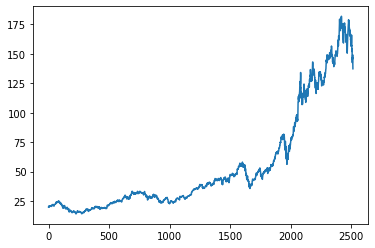

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [7]:
# Split data 
train_size = int(len(df1)*.95) # 65% 
test_size = len(df1) - train_size
train, test = df1[0:train_size,:], df1[train_size:len(df1), :1]

In [8]:
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [11]:
# Reshape to be inputted into LSTM 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
# Create Stacked LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(Dropout(.5))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-traina

In [14]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=250, verbose=1)

Epoch 1/100
10/10 [==============================] - 10s 469ms/step - loss: 0.0362 - val_loss: 0.0487
Epoch 2/100
10/10 [==============================] - 3s 335ms/step - loss: 0.0052 - val_loss: 0.0227
Epoch 3/100
10/10 [==============================] - 4s 352ms/step - loss: 0.0019 - val_loss: 0.0108
Epoch 4/100
10/10 [==============================] - 4s 365ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/100
10/10 [==============================] - 4s 374ms/step - loss: 7.6870e-04 - val_loss: 0.0020
Epoch 6/100
10/10 [==============================] - 4s 362ms/step - loss: 8.0411e-04 - val_loss: 0.0019
Epoch 7/100
10/10 [==============================] - 4s 374ms/step - loss: 6.9227e-04 - val_loss: 0.0030
Epoch 8/100
10/10 [==============================] - 4s 367ms/step - loss: 6.6369e-04 - val_loss: 0.0018
Epoch 9/100
10/10 [==============================] - 4s 381ms/step - loss: 6.2192e-04 - val_loss: 0.0020
Epoch 10/100
10/10 [==============================] - 4s 384ms/step - 

In [15]:
prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

In [16]:
prediction = scaler.inverse_transform(prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [17]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, prediction))

61.29467423692592

In [18]:
math.sqrt(mean_squared_error(y_test, test_prediction))

153.9611566559059

In [20]:
x_input = test[len(test)-100:].reshape(1, -1)

In [21]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
# Prediction for next 30 days

lst_output=[]
n_steps=100
i=0
while i<30:
    if len(temp_input)>100:
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

In [23]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [24]:
print(scaler.inverse_transform(lst_output[0:]))

[[146.68493915]
 [145.38326045]
 [144.28550403]
 [143.44986043]
 [142.88407301]
 [142.56095481]
 [142.43513745]
 [142.45643424]
 [142.57818457]
 [142.76175169]
 [142.97783498]
 [143.20537807]
 [143.43013635]
 [143.64244312]
 [143.83566692]
 [144.00480912]
 [144.14590286]
 [144.25555229]
 [144.3308123 ]
 [144.369419  ]
 [144.36958929]
 [144.33061196]
 [144.25250703]
 [144.13623617]
 [143.98363254]
 [143.79731066]
 [143.58056622]
 [143.3370856 ]
 [143.07105603]
 [142.78677492]]


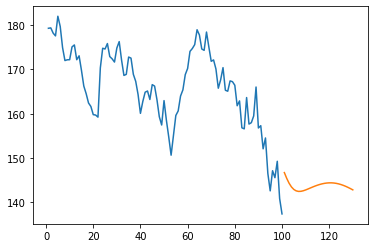

In [25]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

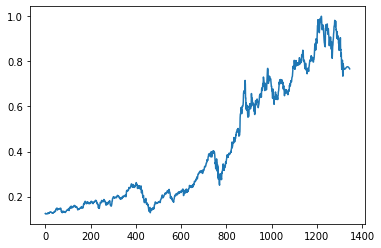

In [26]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [27]:
df3=scaler.inverse_transform(df3).tolist()

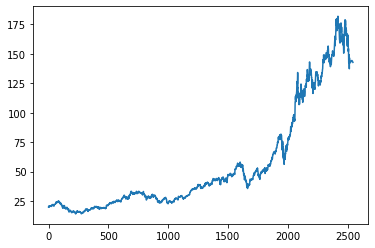

In [28]:
plt.plot(df3)

In [29]:
import time
from datetime import datetime

SECONDS_IN_DAY = 86400

now = int( time.time())

data_set = {"c": [], "t": []}
inversed_output = scaler.inverse_transform(lst_output)
inversed_output.tolist()
for i in range(len(inversed_output)):
    now = SECONDS_IN_DAY + now
    data_set["c"].insert(i, round(float(inversed_output[i]), 2))
    data_set["t"].insert(i, int(now))

In [30]:
import json
with open('../src/stock_json/aapl.json', 'w', encoding='utf-8') as f:
    json.dump(data_set, f, ensure_ascii=False, indent=4)